In [1]:
%matplotlib notebook
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.fits as pf
from astropy.stats import mad_std
from astropy.visualization import ZScaleInterval
import ccdproc as ccdp
from astropy import units as u

from astropy.nddata import CCDData
from iraf_um import imstat, inv_median

import warnings
from astropy.utils.exceptions import AstropyWarning

import astroalign as aa
from copy import deepcopy

***Path***

In [2]:
path = 'E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/'

path_dict = { 'bias' : '2024-09-23-lyon-mtp/bias/', 'flat_r' : '2024-09-24-lyon-mtp/flat/filtre_r/', 'flat_g' : '2024-09-24-lyon-mtp/flat/filtre_g/',
              'dark' : '2024-09-23-lyon-mtp/dark/', 'baseline_23' : '2024-09-23-lyon-mtp/baseline/', 'baseline_24' : '2024-09-24-lyon-mtp/baseline/',
              'obs_sec_r' : '2024-09-23-lyon-mtp/observation_secondaire/', 'obs_sec_g' : '2024-09-24-lyon-mtp/observation_secondaire/',
              'obs_pri_r' : '2024-09-24-lyon-mtp/observation_primaire/', 'baseline_23_t' : '2024-09-23-lyon-mtp_t/baseline/' , 
              'baseline_24_t' : '2024-09-24-lyon-mtp_t/baseline/', 'obs_sec_r_t' : '2024-09-23-lyon-mtp_t/observation_secondaire/',
              'obs_sec_g_t' : '2024-09-24-lyon-mtp_t/observation_secondaire/', 'obs_pri_r_t' : '2024-09-24-lyon-mtp_t/observation_primaire/', 
              'baseline_23_c' : '2024-09-23-lyon-mtp_c/baseline/' , 'baseline_24_c' : '2024-09-24-lyon-mtp_c/baseline/',
              'obs_sec_r_c' : '2024-09-23-lyon-mtp_c/observation_secondaire/', 'obs_sec_g_c' : '2024-09-24-lyon-mtp_c/observation_secondaire/',
              'obs_pri_r_c' : '2024-09-24-lyon-mtp_c/observation_primaire/' }

print(path+path_dict['bias'])

E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp/bias/


***CCD Char***

In [3]:
ccd_gain = 1.47 * u.electron / u.adu
ccd_ron = 11 * u.electron

***Master bias***

In [8]:
ifc_raw = ccdp.ImageFileCollection(path+path_dict['bias'])
ifc_bias = ifc_raw.filter(imagetyp='Bias Frame')
warnings.filterwarnings("ignore", category=AstropyWarning)
master_bias = ccdp.combine(ifc_bias.files_filtered(include_path=True), unit='adu', combine='average', mem_limit=9000.e6)
warnings.filterwarnings("default")
master_bias.meta['COMBINED'] = True
master_bias.write(path+'master_bias.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

***Master flat***

In [9]:
ifc_raw = [ ccdp.ImageFileCollection(path+path_dict['flat_r']), ccdp.ImageFileCollection(path+path_dict['flat_g']) ]
ifc_flatH = [ ifc_raw[0].filter(imagetyp='Flat Field'), ifc_raw[1].filter(imagetyp='Flat Field') ]
master_flatH = [None,None]
for i in range(len(ifc_flatH)):
    warnings.filterwarnings("ignore", category=AstropyWarning)
    master_flatH[i] = ccdp.combine(ifc_flatH[i].files_filtered(include_path=True), unit='adu', combine='average', mem_limit=9000.e6)
    warnings.filterwarnings("default")
    master_flatH[i].meta['COMBINED'] = True
    master_flatH[i] = ccdp.subtract_bias(master_flatH[i], master_bias)

master_flatH[0].write(path + 'master_flatH_r.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)
master_flatH[1].write(path + 'master_flatH_g.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

***Master dark***

In [10]:
ifc_raw = ccdp.ImageFileCollection(path+path_dict['dark'])
ifc_dark = ifc_raw.filter()
warnings.filterwarnings("ignore", category=AstropyWarning)
master_dark = ccdp.combine(ifc_dark.files_filtered(include_path=True), unit='adu', combine='average', mem_limit=9000.e6)
warnings.filterwarnings("default")
master_dark.meta['COMBINED'] = True
master_dark.write(path+'master_dark.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

In [4]:
warnings.filterwarnings("ignore", category=AstropyWarning)
master_bias = ccdp.CCDData.read(path + 'master_bias.fit', unit='adu')
master_bias.to_hdu().info()
print('\n')
master_flatH_g = ccdp.CCDData.read(path + 'master_flatH_g.fit', unit='adu')
master_flatH_g.to_hdu().info()
print('\n')
master_flatH_r = ccdp.CCDData.read(path + 'master_flatH_r.fit', unit='adu')
master_flatH_r.to_hdu().info()
print('\n')
master_dark = ccdp.CCDData.read(path+'master_dark.fit', unit='adu')
master_flatH_r.to_hdu().info()
warnings.filterwarnings("default")

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (3072, 2047)   float64   


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3072, 2047)   float64   


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3072, 2047)   float64   


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.n

***Traitement image***

In [ ]:
input = ['baseline_23', 'baseline_24', 'obs_sec_r', 'obs_sec_g','obs_pri_r' ]
output = ['baseline_23_t', 'baseline_24_t', 'obs_sec_r_t', 'obs_sec_g_t','obs_pri_r_t' ]
for collection in input:
    ifc_raw = ccdp.ImageFileCollection(path+path_dict[collection])
    ifc_sci = ifc_raw.filter(imagetyp='Light Frame')
    for image in ifc_sci.summary['file']:
        warnings.filterwarnings("ignore", category=AstropyWarning)
        name = os.path.split(path+path_dict[collection]+image)[1]
        print(path+path_dict[output[input.index(collection)]])
        ccd_sci = ccdp.CCDData.read(image, unit='adu')
        ccd_sci_b = ccdp.subtract_bias(ccd_sci, master_bias)
        ccd_sci_bf = ccdp.flat_correct(ccd_sci_b, master_flatH_r)
        ccd_sci_bfd = ccdp.subtract_dark(ccd_sci_bf, master_dark, exposure_time=10, exposure_unit=u.second)
        ccd_sci_bfdg = ccdp.gain_correct(ccd_sci_bfd, ccd_gain)
        ccd_sci_bfdg.write(path+path_dict[output[input.index(collection)]]+name, overwrite=True)
        warnings.filterwarnings("default")

In [6]:
input = ['baseline_23', 'baseline_24', 'obs_sec_r', 'obs_sec_g','obs_pri_r' ]
output = ['baseline_23_t', 'baseline_24_t', 'obs_sec_r_t', 'obs_sec_g_t','obs_pri_r_t' ]

collection = 'baseline_23'

ifc_raw = ccdp.ImageFileCollection(path+path_dict[collection])
ifc_sci = ifc_raw.filter(imagetyp='Light Frame')
for image in ifc_sci.summary['file']:
    warnings.filterwarnings("ignore", category=AstropyWarning)
    name = os.path.split(path+path_dict[collection]+image)[1]
    print(path+path_dict[output[input.index(collection)]]+name)
    ccd_sci = ccdp.CCDData.read(image, unit='adu')
    ccd_sci_b = ccdp.subtract_bias(ccd_sci, master_bias)
    ccd_sci_bf = ccdp.flat_correct(ccd_sci_b, master_flatH_r)
    ccd_sci_bfd = ccdp.subtract_dark(ccd_sci_bf, master_dark, exposure_time=10, exposure_unit=u.second)
    ccd_sci_bfdg = ccdp.gain_correct(ccd_sci_bfd, ccd_gain)
    ccd_sci_bfdg.write(path+path_dict[output[input.index(collection)]]+name, overwrite=True)
    warnings.filterwarnings("default")

E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0001r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0002r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0003r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0004r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0005r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0006r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0007r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0008r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0009r.fit
E:/Documents/Cours_

***recentrer***

In [ ]:
import os
import numpy as np
from copy import deepcopy
import ccdproc as ccdp  # Assuming ccdproc is used for CCDData handling
import astroalign as aa  # Assuming astroalign is used for alignment

input = ['baseline_23_t', 'baseline_24_t', 'obs_sec_r_t', 'obs_sec_g_t', 'obs_pri_r_t']
output = ['baseline_23_c', 'baseline_24_c', 'obs_sec_r_c', 'obs_sec_g_c', 'obs_pri_r_c']

# Chemin d'accès à définir
collection = 'obs_sec_g_t'
output_collection = 'obs_sec_g_c'

# Liste des noms de fichiers alignés à stocker
names = []

# Chemin et fichiers d'entrée (ajuster les variables selon tes besoins)
ifc_raw = ccdp.ImageFileCollection(path + path_dict[collection])
ifc_sci = ifc_raw.filter(imagetyp='Light Frame')

# Référence pour l'alignement
iref = 0
ref_image = None

# Ouvrir l'image de référence
ref_filename = ifc_sci.summary['file'][iref]
ref_image = ccdp.CCDData.read(ref_filename, unit='adu')

# Ouvrir, aligner et sauvegarder chaque image individuellement
for i, image_file in enumerate(ifc_sci.summary['file']):
    try:
        # Lire l'image
        ccd = ccdp.CCDData.read(image_file, unit='adu')
        name = os.path.split(path + path_dict[collection] + image_file)[1]
        names.append(name)

        if i == iref:
            # Si c'est l'image de référence, pas besoin de l'aligner
            ccd_bfa = ccd
            p = None
            print(f"Reference frame: #{i}")
        else:
            # Trouver la transformation pour aligner l'image avec la référence
            p, (pos_img, pos_img_rot) = aa.find_transform(ccd, ref_image, detection_sigma=15, max_control_points=3)
            print(f"Image #{i} aligned to reference frame (#0)")
            print(f"Rotation: {p.rotation * 180.0 / np.pi:.2f} degrees")
            print(f"Scale factor: {p.scale:.2f}")
            print(f"Translation: (x, y) = ({p.translation[0]:.2f}, {p.translation[1]:.2f})")
            
            # Conversion en "little-endian" si nécessaire
            if ccd.data.dtype.byteorder == '>':  # '>' signifie big-endian
                ccd.data = ccd.data.byteswap().view(ccd.data.dtype.newbyteorder('<'))

            # Appliquer la transformation
            img_aligned, footprint = aa.apply_transform(p, ccd, ref_image)
            ccd_bfa = deepcopy(ccd)
            ccd_bfa.data = img_aligned

        # Sauvegarder l'image alignée
        output_path = path + path_dict[output[input.index(collection)]] + names[i]
        ccd_bfa.write(output_path, overwrite=True)
        print(f"Saved aligned image #{i} to {output_path}")

    except Exception as e:
        print(f"Error processing image #{i}: {e}")
        continue

print("Alignment process completed.")


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Reference frame: #0


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #0 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0001g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #1 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (1.49, 1.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #1 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0002g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #2 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (9.07, 0.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #2 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0003g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #3 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (4.80, -0.32)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #3 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0004g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #4 aligned to reference frame (#0)
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (1.58, -0.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #4 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0005g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #5 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (5.55, -1.57)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #5 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0006g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #6 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (6.31, -2.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #6 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0007g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #7 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (-1.75, -4.87)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #7 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0008g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #8 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (3.48, -6.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #8 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0009g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #9 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (5.44, -0.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #9 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0010g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #10 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (-1.08, -4.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #10 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0011g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #11 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (9.16, -6.07)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #11 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0012g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #12 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (11.67, -6.20)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #12 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0013g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #13 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (4.16, -8.97)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #13 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0014g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #14 aligned to reference frame (#0)
Rotation: -0.04 degrees
Scale factor: 1.00
Translation: (x, y) = (1.45, -6.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #14 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0015g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #15 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (4.64, -8.58)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #15 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0016g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #16 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (8.28, -8.73)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #16 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0017g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #17 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (5.41, -9.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #17 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0018g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #18 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (11.03, -13.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #18 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0019g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #19 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (9.05, -12.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #19 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0020g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #20 aligned to reference frame (#0)
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (3.31, -9.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #20 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0021g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #21 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (4.71, -13.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #21 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0022g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #22 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (9.53, -12.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #22 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0023g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #23 aligned to reference frame (#0)
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (-0.20, -10.57)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #23 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0024g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #24 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (7.75, -11.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #24 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0025g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #25 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (9.30, -14.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #25 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0026g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #26 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (5.80, -14.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #26 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0027g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #27 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (9.49, -14.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #27 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0028g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #28 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (14.45, -16.04)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #28 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0029g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #29 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (7.48, -16.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #29 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0030g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #30 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (6.04, -17.17)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #30 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0031g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #31 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (14.28, -17.87)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #31 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0032g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #32 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (14.04, -19.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #32 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0033g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #33 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (8.84, -20.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #33 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0034g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #34 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (8.86, -18.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #34 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0035g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #35 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (11.21, -17.94)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #35 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0036g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #36 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (7.43, -21.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #36 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0037g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #37 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (11.95, -22.07)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #37 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0038g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #38 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (13.86, -23.39)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #38 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0039g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #39 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (16.31, -27.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #39 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0040g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #40 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (13.07, -24.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #40 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0041g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #41 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (13.91, -23.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #41 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0042g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #42 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (13.68, -24.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #42 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0043g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #43 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (11.37, -25.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #43 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0044g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #44 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (16.72, -24.71)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #44 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0045g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #45 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (10.42, -26.65)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #45 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0046g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #46 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (12.38, -28.73)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #46 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0047g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #47 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (21.90, -28.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #47 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0048g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #48 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (19.11, -28.12)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #48 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0049g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #49 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (14.32, -30.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #49 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0050g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #50 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (19.93, -29.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #50 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0051g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #51 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (21.21, -29.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #51 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0052g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #52 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (11.39, -32.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #52 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0053g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #53 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (22.04, -32.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #53 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0054g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #54 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (16.52, -32.88)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #54 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0055g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #55 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (19.07, -32.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #55 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0056g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #56 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (23.16, -30.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #56 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0057g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #57 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (24.51, -34.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #57 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0058g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #58 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (18.40, -34.51)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #58 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0059g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #59 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (18.41, -35.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #59 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0060g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #60 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (20.51, -34.90)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #60 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0061g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #61 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (19.97, -37.81)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #61 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0062g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #62 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (20.26, -34.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #62 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0063g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #63 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (24.87, -39.13)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #63 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0064g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #64 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (27.06, -40.05)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #64 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0065g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #65 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (25.48, -40.51)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #65 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0066g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #66 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (30.91, -39.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #66 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0067g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #67 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (31.45, -40.93)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #67 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0068g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #68 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (24.94, -41.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #68 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0069g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #69 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (28.97, -42.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #69 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0070g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #70 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (31.98, -42.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #70 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0071g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #71 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (29.32, -42.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #71 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0072g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #72 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (29.38, -44.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #72 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0073g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #73 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (33.65, -46.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #73 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0074g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #74 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (33.93, -46.43)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #74 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0075g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #75 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (33.01, -44.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #75 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0076g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #76 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (37.87, -46.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #76 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0077g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #77 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (36.94, -46.71)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #77 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0078g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #78 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (33.56, -46.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #78 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0079g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #79 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (41.68, -48.71)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #79 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0080g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #80 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (41.88, -50.57)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #80 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0081g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #81 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (38.07, -49.13)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #81 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0082g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #82 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (45.51, -51.77)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #82 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0083g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #83 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (47.14, -53.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #83 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0084g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #84 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (44.84, -52.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #84 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0085g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #85 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (44.51, -54.81)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #85 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0086g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #86 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (46.86, -54.07)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #86 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0087g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #87 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (46.53, -53.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #87 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0088g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #88 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (47.92, -55.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #88 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0089g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #89 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (54.87, -57.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #89 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0090g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #90 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (53.02, -56.26)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #90 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0091g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #91 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (48.81, -57.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #91 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0092g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #92 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (60.23, -58.39)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #92 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0093g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #93 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (61.58, -61.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #93 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0094g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #94 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (57.79, -60.88)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #94 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0095g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #95 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (65.45, -61.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #95 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0096g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #96 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (64.65, -61.67)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #96 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0097g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #97 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (60.10, -60.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #97 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0098g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #98 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (66.67, -61.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #98 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0099g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #99 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (66.89, -62.13)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #99 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0100g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #100 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (62.04, -64.05)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #100 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0101g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #101 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (62.54, -64.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #101 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0102g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #102 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (63.28, -64.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #102 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0103g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #103 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (65.71, -66.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #103 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0104g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #104 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (62.80, -66.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #104 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0105g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #105 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (69.73, -66.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #105 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0106g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #106 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (69.08, -67.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #106 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0107g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #107 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (58.28, -67.87)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #107 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0108g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #108 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (69.10, -70.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #108 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0109g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #109 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (65.94, -70.52)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #109 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0110g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #110 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (62.12, -69.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #110 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0111g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #111 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (65.72, -71.02)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #111 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0112g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #112 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (67.52, -70.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #112 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0113g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #113 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (64.47, -70.20)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #113 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0114g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #114 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (69.11, -73.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #114 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0115g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #115 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (67.64, -75.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #115 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0116g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #116 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (64.83, -75.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #116 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0117g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #117 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (62.46, -73.94)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #117 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0118g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #118 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (71.40, -75.56)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #118 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0119g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #119 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (71.19, -77.31)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #119 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0120g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #120 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (67.08, -77.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #120 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0121g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #121 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (70.50, -77.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #121 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0122g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #122 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (72.06, -78.99)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #122 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0123g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #123 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (65.89, -78.08)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #123 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0124g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #124 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (74.28, -78.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #124 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0125g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #125 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (75.83, -78.78)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #125 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0126g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #126 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (74.69, -81.22)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #126 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0127g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #127 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (78.73, -81.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #127 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0128g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #128 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (74.16, -79.77)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #128 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0129g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #129 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (72.52, -82.19)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #129 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0130g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #130 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (74.68, -82.29)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #130 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0131g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #131 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (79.51, -82.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #131 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0132g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #132 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (78.95, -81.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #132 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0133g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #133 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (70.99, -83.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #133 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0134g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #134 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (79.03, -85.71)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #134 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0135g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #135 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (84.18, -87.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #135 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0136g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #136 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (74.59, -85.95)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #136 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0137g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #137 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (77.63, -86.93)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #137 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0138g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #138 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (77.48, -86.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #138 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0139g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #139 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (71.27, -86.44)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #139 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0140g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #140 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (78.28, -88.53)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #140 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0141g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #141 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (79.86, -90.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #141 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0142g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #142 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (72.34, -90.10)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #142 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0143g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #143 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (76.48, -89.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #143 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0144g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #144 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (74.23, -90.56)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #144 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0145g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #145 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (76.71, -90.28)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #145 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0146g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #146 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (75.62, -91.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #146 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0147g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #147 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (74.41, -93.24)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #147 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0148g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #148 aligned to reference frame (#0)
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (75.93, -92.57)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #148 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0149g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #149 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (70.27, -93.32)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #149 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0150g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #150 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (75.61, -94.98)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #150 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0151g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #151 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (75.65, -95.98)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #151 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0152g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #152 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (72.04, -95.06)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #152 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0153g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #153 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (79.83, -96.92)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #153 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0154g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #154 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (78.56, -95.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #154 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0155g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #155 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (72.70, -95.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #155 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0156g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #156 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (76.69, -97.02)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #156 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0157g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #157 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (79.15, -98.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #157 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0158g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #158 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (77.73, -101.20)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #158 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0159g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #159 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (77.10, -98.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #159 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0160g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #160 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (80.85, -100.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #160 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0161g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #161 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (80.03, -101.79)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #161 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0162g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #162 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (77.54, -99.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #162 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0163g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #163 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (81.65, -100.64)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #163 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0164g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #164 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (79.69, -100.96)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #164 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0165g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #165 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (79.32, -101.99)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #165 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0166g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #166 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (83.68, -105.03)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #166 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0167g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #167 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (84.33, -105.28)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #167 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0168g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #168 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (81.11, -104.93)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #168 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0169g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #169 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (82.95, -103.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #169 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0170g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #170 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (85.88, -106.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #170 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0171g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #171 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (86.82, -105.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #171 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0172g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #172 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (88.83, -106.95)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #172 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0173g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #173 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (88.75, -109.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #173 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0174g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #174 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (86.32, -107.73)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #174 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0175g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #175 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (89.21, -109.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #175 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0176g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #176 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (85.34, -111.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #176 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0177g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #177 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (87.24, -110.20)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #177 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0178g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #178 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (87.88, -111.23)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #178 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0179g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #179 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (87.34, -109.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #179 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0180g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #180 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (92.45, -111.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #180 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0181g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #181 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (87.86, -113.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #181 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0182g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #182 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (91.02, -113.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #182 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0183g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #183 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (93.28, -113.25)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #183 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0184g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #184 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (89.70, -113.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #184 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0185g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #185 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (95.25, -116.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #185 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0186g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #186 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (96.27, -117.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #186 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0187g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #187 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (98.12, -117.38)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #187 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0188g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #188 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (98.48, -118.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #188 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0189g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #189 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (97.19, -119.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #189 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0190g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #190 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (99.21, -117.87)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #190 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0191g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #191 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (98.42, -118.79)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #191 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0192g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #192 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (100.90, -119.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #192 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0193g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #193 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (103.02, -121.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #193 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0194g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #194 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (103.55, -121.23)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #194 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0195g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #195 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (106.52, -122.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #195 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0196g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #196 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (107.70, -122.46)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #196 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0197g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #197 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (111.10, -124.71)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #197 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0198g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #198 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (114.11, -124.77)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #198 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0199g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #199 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (113.23, -125.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #199 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0200g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #200 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (110.79, -125.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #200 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0201g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #201 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (115.27, -125.23)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #201 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0202g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #202 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (116.70, -128.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #202 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0203g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #203 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (119.87, -127.90)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #203 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0204g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #204 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (118.67, -127.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #204 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0205g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #205 aligned to reference frame (#0)
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (121.75, -127.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #205 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0206g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #206 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (121.66, -130.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #206 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0207g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #207 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (123.22, -130.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #207 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0208g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #208 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (125.04, -132.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #208 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0209g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #209 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (122.70, -131.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #209 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0210g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #210: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #211: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #212: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #213: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #214 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (123.69, -133.43)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #214 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0215g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #215: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #216: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #217 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (127.57, -136.16)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #217 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0218g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #218: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #219: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #220 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (131.95, -140.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #220 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0221g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #221 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (131.37, -140.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #221 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0222g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #222: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #223: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #224: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #225 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (133.06, -142.46)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #225 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0226g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #226: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #227: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #228: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #229 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (138.98, -142.93)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #229 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0230g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #230 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (144.85, -144.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #230 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0231g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #231 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (142.60, -146.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #231 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0232g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #232: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #233: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #234: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #235: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #236: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #237: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #238: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #239: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #240: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #241: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #242: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #243: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #244: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #245: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #246: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #247: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #248: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #249: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #250: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #251 aligned to reference frame (#0)
Rotation: -150.79 degrees
Scale factor: 1.50
Translation: (x, y) = (2684.59, 3445.67)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #251 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0252g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #252 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (169.77, -158.93)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #252 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0253g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #253: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #254 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (169.76, -161.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #254 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0255g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #255 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (171.01, -161.70)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #255 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0256g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #256: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #257: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #258: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #259: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #260: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #261: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #262: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #263 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (176.58, -168.13)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #263 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0264g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #264: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #265 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (183.07, -166.85)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #265 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0266g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #266: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #267: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #268 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (181.71, -170.43)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #268 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0269g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #269: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #270: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #271: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #272: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #273: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #274: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #275: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #276: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #277: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #278: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #279: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #280: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #281 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (195.58, -177.85)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #281 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0282g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #282: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #283: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #284 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (194.52, -180.16)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #284 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0285g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #285 aligned to reference frame (#0)
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (197.62, -178.38)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #285 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0286g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #286: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #287: Reference stars in source image are less than the minimum value (3).
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #288: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #289: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #290: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #291: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #292: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #293 aligned to reference frame (#0)
Rotation: -0.06 degrees
Scale factor: 1.00
Translation: (x, y) = (205.15, -183.13)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #293 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0294g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #294 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (210.75, -185.24)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #294 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0295g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #295: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Error processing image #296: List of matching triangles exhausted before an acceptable transformation was found
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #297 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (213.37, -185.08)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #297 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0298g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #298 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (213.73, -184.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #298 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0299g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #299 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (209.33, -189.29)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #299 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0300g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #300 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (214.29, -186.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #300 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0301g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #301 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (211.97, -187.46)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #301 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0302g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #302 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (212.30, -189.70)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #302 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0303g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #303 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (215.85, -188.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #303 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0304g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #304 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (215.49, -188.81)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #304 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0305g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #305 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (215.15, -187.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #305 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0306g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #306 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (218.53, -191.51)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #306 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0307g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #307 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (218.73, -188.98)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #307 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0308g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #308 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (218.09, -189.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #308 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0309g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #309 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (217.86, -191.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #309 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0310g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #310 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (219.54, -192.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #310 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0311g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #311 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (218.86, -193.90)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #311 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0312g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #312 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (216.87, -194.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #312 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0313g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #313 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (218.52, -194.22)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #313 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0314g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #314 aligned to reference frame (#0)
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (218.35, -193.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #314 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0315g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #315 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (221.25, -193.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #315 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0316g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #316 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (220.88, -194.54)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #316 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0317g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #317 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (222.43, -193.96)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #317 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0318g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #318 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (224.31, -194.25)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #318 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0319g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #319 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (219.78, -197.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #319 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0320g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #320 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (221.92, -197.60)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #320 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0321g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #321 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (223.37, -195.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #321 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0322g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #322 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (224.81, -196.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #322 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0323g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #323 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (224.79, -198.21)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #323 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0324g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #324 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (226.80, -197.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #324 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0325g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #325 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (228.75, -199.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #325 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0326g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #326 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (65.92, 81.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #326 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0327g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #327 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (66.28, 77.82)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #327 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0328g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #328 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (57.27, 76.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #328 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0329g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #329 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (67.70, 74.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #329 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0330g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #330 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (66.79, 74.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #330 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0331g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #331 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (55.74, 77.12)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #331 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0332g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #332 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (62.01, 73.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #332 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0333g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #333 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (64.51, 75.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #333 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0334g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #334 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (60.69, 72.87)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #334 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0335g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #335 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (62.03, 71.57)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #335 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0336g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #336 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (67.00, 73.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #336 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0337g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #337 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (70.01, 72.64)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #337 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0338g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #338 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (65.22, 74.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #338 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0339g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #339 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (72.09, 73.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #339 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0340g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #340 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (71.20, 68.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #340 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0341g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #341 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (64.94, 69.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #341 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0342g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #342 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (71.76, 70.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #342 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0343g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #343 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (77.09, 70.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #343 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0344g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #344 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (71.18, 71.65)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #344 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0345g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #345 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (77.02, 67.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #345 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0346g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #346 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (79.54, 68.90)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #346 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0347g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #347 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (79.39, 68.10)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #347 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0348g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #348 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (84.09, 64.56)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #348 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0349g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #349 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (79.96, 64.11)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #349 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0350g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #350 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (76.86, 66.03)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #350 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0351g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #351 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (80.03, 64.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #351 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0352g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #352 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (87.87, 63.82)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #352 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0353g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #353 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (86.27, 66.21)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #353 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0354g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #354 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (85.59, 64.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #354 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0355g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #355 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (94.37, 64.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #355 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0356g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #356 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (94.85, 62.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #356 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0357g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #357 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (87.93, 62.82)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #357 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0358g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #358 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (95.20, 61.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #358 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0359g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #359 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (93.14, 59.85)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #359 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0360g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #360 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (87.40, 61.16)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #360 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0361g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #361 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (99.79, 60.04)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #361 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0362g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #362 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (95.06, 59.54)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #362 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0363g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #363 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (90.25, 56.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #363 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0364g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #364 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (100.56, 60.04)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #364 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0365g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #365 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (100.94, 57.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #365 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0366g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #366 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (95.83, 54.51)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #366 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0367g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #367 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (102.64, 54.44)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #367 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0368g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #368 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (104.59, 55.52)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #368 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0369g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #369 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (98.55, 56.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #369 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0370g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #370 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (101.89, 58.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #370 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0371g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #371 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (108.53, 54.95)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #371 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0372g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #372 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (104.90, 52.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #372 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0373g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #373 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (101.36, 51.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #373 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0374g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #374 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (109.06, 52.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #374 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0375g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #375 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (111.52, 52.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #375 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0376g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #376 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (103.70, 53.44)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #376 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0377g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #377 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (112.14, 50.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #377 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0378g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #378 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (116.51, 51.53)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #378 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0379g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #379 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (109.35, 53.43)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #379 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0380g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #380 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (113.65, 48.03)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #380 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0381g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #381 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (114.53, 48.43)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #381 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0382g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #382 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (111.97, 49.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #382 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0383g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #383 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (113.08, 50.78)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #383 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0384g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #384 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (113.29, 49.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #384 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0385g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #385 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (112.69, 46.53)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #385 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0386g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #386 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (111.90, 46.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #386 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0387g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #387 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (116.88, 46.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #387 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0388g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #388 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (114.41, 42.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #388 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0389g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #389 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (110.50, 43.28)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #389 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0390g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #390 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (120.33, 44.97)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #390 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0391g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #391 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (120.45, 45.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #391 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0392g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #392 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (118.56, 42.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #392 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0393g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #393 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (123.57, 43.38)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #393 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0394g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #394 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (122.03, 42.81)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #394 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0395g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #395 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (119.64, 42.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #395 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0396g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #396 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (116.51, 42.02)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #396 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0397g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #397 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (117.83, 40.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #397 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0398g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #398 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (116.59, 39.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #398 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0399g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #399 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (122.56, 39.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #399 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0400g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #400 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (127.28, 39.65)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #400 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0401g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #401 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (122.94, 38.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #401 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0402g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #402 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (119.45, 37.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #402 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0403g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #403 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (129.39, 40.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #403 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0404g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #404 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (127.29, 38.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #404 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0405g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #405 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (124.47, 38.56)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #405 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0406g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #406 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (129.61, 36.70)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #406 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0407g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #407 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (125.58, 37.02)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #407 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0408g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #408 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (123.40, 35.81)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #408 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0409g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #409 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (130.75, 34.54)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #409 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0410g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #410 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (134.15, 33.26)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #410 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0411g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #411 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (126.54, 33.94)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #411 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0412g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #412 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (132.55, 34.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #412 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0413g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #413 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (138.52, 33.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #413 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0414g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #414 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (137.12, 33.24)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #414 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0415g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #415 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (136.76, 32.16)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #415 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0416g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #416 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (137.94, 30.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #416 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0417g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #417 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (138.68, 28.88)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #417 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0418g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #418 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (133.48, 29.12)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #418 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0419g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #419 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (142.08, 28.52)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #419 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0420g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #420 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (140.41, 29.21)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #420 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0421g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #421 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (134.74, 29.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #421 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0422g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #422 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (142.47, 29.97)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #422 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0423g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #423 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (142.64, 28.28)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #423 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0424g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #424 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (142.09, 28.08)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #424 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0425g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #425 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (148.06, 28.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #425 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0426g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #426 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (144.68, 26.00)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #426 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0427g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #427 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (142.83, 27.03)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #427 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0428g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #428 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (144.36, 27.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #428 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0429g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #429 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (147.06, 27.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #429 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0430g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #430 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (147.39, 23.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #430 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0431g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #431 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (145.08, 24.12)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #431 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0432g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #432 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (148.27, 23.12)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #432 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0433g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #433 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (145.28, 24.44)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #433 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0434g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #434 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (142.99, 24.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #434 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0435g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #435 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (152.15, 24.58)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #435 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0436g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #436 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (154.76, 22.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #436 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0437g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #437 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (152.27, 23.95)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #437 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0438g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #438 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (156.28, 22.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #438 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0439g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #439 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (154.16, 21.60)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #439 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0440g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #440 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (148.86, 24.56)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #440 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0441g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #441 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (152.58, 18.82)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #441 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0442g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #442 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (158.17, 18.94)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #442 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0443g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #443 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (149.21, 20.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #443 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0444g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #444 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (159.78, 18.52)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #444 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0445g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #445 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (157.58, 18.35)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #445 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0446g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #446 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (155.26, 19.70)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #446 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0447g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #447 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (156.37, 18.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #447 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0448g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #448 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (162.99, 16.71)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #448 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0449g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #449 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (160.79, 15.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #449 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0450g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #450 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (157.96, 14.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #450 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0451g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #451 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (166.03, 14.53)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #451 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0452g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #452 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (166.29, 15.21)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #452 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0453g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #453 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (155.59, 15.35)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #453 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0454g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #454 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (164.44, 15.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #454 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0455g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #455 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (165.07, 15.25)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #455 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0456g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #456 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (158.77, 14.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #456 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0457g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #457 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (169.49, 14.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #457 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0458g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #458 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (171.30, 12.60)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #458 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0459g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #459 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (161.11, 9.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #459 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0460g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #460 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (167.77, 9.94)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #460 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0461g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #461 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (169.53, 11.23)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #461 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0462g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #462 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (166.14, 11.22)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #462 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0463g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #463 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (165.19, 13.99)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #463 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0464g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #464 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (167.17, 12.54)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #464 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0465g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #465 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (165.21, 11.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #465 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0466g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #466 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (165.16, 10.10)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #466 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0467g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #467 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (176.17, 9.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #467 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0468g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #468 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (169.06, 8.79)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #468 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0469g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #469 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (165.57, 9.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #469 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0470g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #470 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (172.39, 8.95)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #470 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0471g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #471 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (170.65, 6.60)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #471 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0472g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #472 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (165.99, 7.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #472 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0473g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #473 aligned to reference frame (#0)
Rotation: -0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (169.64, 10.64)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #473 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0474g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #474 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (174.71, 3.51)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #474 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0475g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #475 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (166.29, 9.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #475 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0476g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #476 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (168.48, 8.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #476 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0477g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #477 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (174.53, 6.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #477 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0478g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #478 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (168.53, 5.11)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #478 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0479g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #479 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (168.32, 3.17)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #479 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0480g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #480 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (173.83, 5.97)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #480 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0481g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #481 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (171.07, 3.22)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #481 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0482g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #482 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (175.28, 4.02)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #482 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0483g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #483 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (177.48, 6.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #483 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0484g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #484 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (177.17, 0.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #484 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0485g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #485 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (168.51, 5.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #485 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0486g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #486 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (174.37, -1.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #486 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0487g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #487 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (178.18, 2.16)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #487 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0488g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #488 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (166.89, 2.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #488 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0489g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #489 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (179.04, -0.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #489 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0490g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #490 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (177.47, 1.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #490 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0491g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #491 aligned to reference frame (#0)
Rotation: -0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (174.36, 0.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #491 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0492g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #492 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (174.51, 1.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #492 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0493g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #493 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (175.17, 0.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #493 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0494g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #494 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (180.64, 0.73)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #494 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0495g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #495 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (182.86, 1.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #495 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0496g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #496 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (177.43, 1.11)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #496 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0497g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #497 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (177.42, -1.52)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #497 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0498g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #498 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (176.91, -4.03)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #498 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0499g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #499 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (183.46, 0.10)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #499 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0500g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #500 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (185.63, -2.88)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #500 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0501g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #501 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (182.02, -1.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #501 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0502g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #502 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (186.26, -3.13)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #502 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0503g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #503 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (182.20, -6.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #503 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0504g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #504 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (181.47, -4.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #504 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0505g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #505 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (183.02, -6.00)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #505 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0506g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #506 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (186.98, -5.35)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #506 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0507g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #507 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (189.86, -6.78)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #507 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0508g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #508 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (189.46, -7.10)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #508 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0509g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #509 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (192.50, -5.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #509 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0510g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #510 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (191.98, -4.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #510 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0511g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #511 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (191.51, -9.04)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #511 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0512g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #512 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (196.21, -8.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #512 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0513g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #513 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (197.51, -6.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #513 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0514g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #514 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (196.63, -7.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #514 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0515g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #515 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (200.48, -5.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #515 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0516g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #516 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (204.28, -2.81)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #516 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0517g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #517 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (203.02, -5.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #517 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0518g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #518 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (202.51, -6.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #518 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0519g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #519 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (203.65, -9.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #519 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0520g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #520 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (204.48, -8.34)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #520 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0521g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #521 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (209.48, -7.29)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #521 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0522g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #522 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (215.69, -5.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #522 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0523g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #523 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (208.77, -9.05)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #523 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0524g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #524 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (209.78, -10.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #524 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0525g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #525 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (210.80, -9.56)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #525 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0526g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #526 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (214.06, -6.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #526 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0527g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #527 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (217.72, -8.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #527 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0528g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #528 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (216.92, -10.02)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #528 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0529g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #529 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (218.20, -10.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #529 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0530g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #530 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (214.13, -9.56)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #530 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0531g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #531 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (218.22, -9.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #531 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0532g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #532 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (222.06, -11.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #532 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0533g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #533 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (217.69, -10.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #533 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0534g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #534 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (219.97, -13.79)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #534 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0535g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #535 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (217.04, -14.35)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #535 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0536g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #536 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (217.34, -10.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #536 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0537g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #537 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (222.41, -7.99)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #537 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0538g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #538 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (222.31, -8.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #538 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0539g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #539 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (223.84, -12.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #539 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0540g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #540 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (221.78, -13.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #540 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0541g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #541 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (221.84, -10.82)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #541 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0542g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #542 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (222.14, -12.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #542 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0543g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #543 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (219.06, -15.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #543 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0544g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #544 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (223.03, -12.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #544 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0545g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #545 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (223.92, -13.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #545 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0546g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #546 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (224.78, -12.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #546 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0547g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #547 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (229.96, -13.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #547 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0548g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #548 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (226.66, -16.12)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #548 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0549g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #549 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (225.80, -13.74)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #549 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0550g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #550 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (229.35, -11.90)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #550 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0551g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #551 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (228.57, -12.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #551 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0552g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #552 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (226.77, -18.60)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #552 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0553g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #553 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (228.81, -17.23)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #553 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0554g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #554 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (228.15, -15.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #554 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0555g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #555 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (231.26, -15.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #555 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0556g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #556 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (229.53, -19.65)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #556 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0557g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #557 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (235.05, -16.22)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #557 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0558g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #558 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (234.69, -18.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #558 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0559g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #559 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (235.68, -16.99)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #559 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0560g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #560 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (237.86, -19.54)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #560 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0561g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #561 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (237.53, -17.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #561 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0562g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #562 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (237.47, -17.39)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #562 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0563g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #563 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (241.82, -18.45)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #563 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0564g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #564 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (240.92, -16.87)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #564 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0565g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #565 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (241.11, -19.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #565 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0566g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #566 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (239.95, -22.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #566 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0567g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #567 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (241.36, -18.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #567 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0568g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #568 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (241.02, -18.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #568 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0569g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #569 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (243.71, -19.80)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #569 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0570g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #570 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (241.26, -23.03)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #570 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0571g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #571 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (243.63, -23.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #571 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0572g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #572 aligned to reference frame (#0)
Rotation: 0.00 degrees
Scale factor: 1.00
Translation: (x, y) = (241.96, -23.79)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #572 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0573g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #573 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (246.60, -21.21)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #573 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0574g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #574 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (248.09, -23.17)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #574 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0575g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #575 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (243.90, -26.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #575 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0576g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #576 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (244.39, -25.38)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #576 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0577g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #577 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (247.17, -22.32)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #577 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0578g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #578 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (247.47, -22.26)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #578 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0579g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #579 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (249.13, -25.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #579 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0580g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #580 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (250.77, -27.08)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #580 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0581g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #581 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (252.99, -24.65)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #581 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0582g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #582 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (251.26, -23.68)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #582 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0583g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #583 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (250.24, -24.47)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #583 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0584g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #584 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (252.96, -25.77)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #584 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0585g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #585 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (251.79, -24.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #585 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0586g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #586 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (252.64, -26.70)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #586 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0587g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #587 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (253.16, -27.39)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #587 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0588g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #588 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (252.56, -26.73)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #588 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0589g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #589 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (251.62, -25.99)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #589 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0590g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #590 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (254.79, -27.67)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #590 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0591g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #591 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (252.41, -28.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #591 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0592g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #592 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (253.38, -29.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #592 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0593g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #593 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (253.98, -30.02)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #593 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0594g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #594 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (255.99, -27.29)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #594 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0595g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #595 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (259.26, -29.40)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #595 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0596g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #596 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (258.87, -31.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #596 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0597g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #597 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (257.73, -31.70)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #597 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0598g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #598 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (260.65, -30.97)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #598 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0599g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #599 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (259.77, -32.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #599 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0600g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #600 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (262.57, -32.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #600 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0601g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #601 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (262.26, -30.85)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #601 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0602g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #602 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (263.79, -31.97)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #602 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0603g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #603 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (267.12, -33.17)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #603 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0604g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #604 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (265.67, -32.53)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #604 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0605g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #605 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (267.14, -31.79)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #605 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0606g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #606 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (266.00, -34.04)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #606 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0607g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #607 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (264.99, -35.10)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #607 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0608g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #608 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (270.68, -32.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #608 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0609g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #609 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (270.55, -34.10)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #609 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0610g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #610 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (267.36, -34.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #610 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0611g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #611 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (268.31, -34.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #611 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0612g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #612 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (272.64, -34.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #612 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0613g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #613 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (272.05, -34.98)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #613 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0614g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #614 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (270.75, -35.44)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #614 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0615g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #615 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (274.01, -35.94)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #615 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0616g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #616 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (278.41, -35.21)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #616 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0617g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #617 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (275.32, -37.26)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #617 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0618g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #618 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (279.77, -36.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #618 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0619g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #619 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (279.70, -34.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #619 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0620g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #620 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (278.46, -37.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #620 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0621g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #621 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (281.63, -36.41)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #621 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0622g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #622 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (280.98, -38.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #622 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0623g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #623 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (282.12, -39.79)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #623 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0624g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #624 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (287.50, -36.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #624 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0625g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #625 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (290.58, -37.76)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #625 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0626g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #626 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (287.80, -37.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #626 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0627g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #627 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (289.81, -39.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #627 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0628g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #628 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (292.49, -37.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #628 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0629g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #629 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (293.00, -40.73)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #629 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0630g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #630 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (292.56, -38.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #630 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0631g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #631 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (294.35, -39.71)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #631 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0632g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #632 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (296.78, -41.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #632 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0633g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #633 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (294.95, -41.85)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #633 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0634g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #634 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (297.06, -38.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #634 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0635g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #635 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (299.33, -44.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #635 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0636g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #636 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (299.98, -43.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #636 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0637g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #637 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (304.72, -42.32)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #637 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0638g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #638 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (304.20, -42.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #638 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0639g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #639 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (301.62, -43.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #639 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0640g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #640 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (303.02, -41.85)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #640 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0641g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #641 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (304.97, -44.04)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #641 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0642g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #642 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (301.62, -42.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #642 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0643g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #643 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (306.64, -42.48)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #643 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0644g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #644 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (306.86, -46.93)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #644 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0645g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #645 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (306.23, -46.08)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #645 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0646g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #646 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (305.68, -42.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #646 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0647g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #647 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (304.72, -44.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #647 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0648g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #648 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (307.62, -45.55)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #648 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0649g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #649 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (308.68, -43.59)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #649 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0650g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #650 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (308.05, -45.38)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #650 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0651g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #651 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (306.93, -47.25)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #651 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0652g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #652 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (308.08, -47.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #652 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0653g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #653 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (311.98, -47.05)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #653 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0654g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #654 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (315.62, -47.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #654 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0655g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #655 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (315.08, -49.04)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #655 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0656g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #656 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (316.91, -49.30)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #656 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0657g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #657 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (313.77, -49.60)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #657 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0658g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #658 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (318.26, -47.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #658 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0659g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #659 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (319.82, -47.07)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #659 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0660g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #660 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (320.78, -50.32)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #660 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0661g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #661 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (321.19, -49.39)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #661 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0662g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #662 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (324.06, -49.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #662 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0663g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #663 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (321.68, -49.96)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #663 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0664g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #664 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (325.12, -51.28)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #664 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0665g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #665 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (324.35, -54.00)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #665 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0666g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


Image #666 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (326.71, -53.67)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #666 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0667g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #667 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (329.14, -52.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #667 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0668g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #668 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (328.99, -49.36)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #668 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0669g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #669 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (329.96, -52.65)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #669 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0670g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #670 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (333.17, -55.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #670 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0671g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #671 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (330.79, -52.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #671 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0672g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #672 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (331.75, -54.96)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #672 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0673g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #673 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (334.09, -53.42)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #673 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0674g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #674 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (333.09, -54.46)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #674 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0675g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #675 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (334.92, -54.75)
Saved aligned image #675 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0676g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #676 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (334.35, -55.25)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #676 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0677g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #677 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (338.32, -54.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #677 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0678g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #678 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (338.98, -54.57)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #678 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0679g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #679 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (338.45, -56.74)
Saved aligned image #679 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0680g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #680 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (338.31, -60.07)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #680 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0681g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #681 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (340.34, -54.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #681 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0682g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #682 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (343.56, -54.50)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #682 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0683g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #683 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (345.46, -55.61)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #683 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0684g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #684 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (341.74, -56.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #684 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0685g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #685 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (342.76, -56.43)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #685 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0686g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #686 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (344.23, -59.09)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #686 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0687g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #687 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (344.36, -59.72)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #687 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0688g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #688 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (347.13, -58.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #688 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0689g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #689 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (346.90, -55.49)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #689 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0690g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #690 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (346.44, -58.32)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #690 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0691g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #691 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (343.59, -60.89)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #691 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0692g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #692 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (344.42, -59.01)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #692 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0693g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #693 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (343.55, -55.05)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #693 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0694g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #694 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (344.78, -55.55)
Saved aligned image #694 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0695g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #695 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (343.27, -56.75)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #695 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0696g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #696 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (343.90, -53.66)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #696 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0697g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #697 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (343.92, -51.92)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #697 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0698g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #698 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (346.06, -56.39)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #698 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0699g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #699 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (346.59, -57.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #699 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0700g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #700 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (348.55, -55.28)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #700 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0701g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #701 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (347.23, -55.11)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #701 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0702g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #702 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (345.84, -54.00)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #702 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0703g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #703 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (347.10, -55.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #703 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0704g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #704 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (351.21, -56.18)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #704 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0705g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #705 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (347.83, -58.86)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #705 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0706g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #706 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (345.36, -59.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #706 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0707g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #707 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (347.69, -61.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #707 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0708g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #708 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (348.66, -59.06)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #708 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0709g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #709 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (349.44, -60.54)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #709 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0710g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #710 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (350.52, -61.63)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #710 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0711g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #711 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (351.89, -56.81)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #711 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0712g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #712 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (351.87, -57.54)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #712 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0713g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #713 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (353.95, -58.90)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #713 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0714g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #714 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (352.86, -62.33)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #714 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0715g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #715 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (353.51, -63.14)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #715 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0716g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #716 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (348.31, -61.91)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #716 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0717g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #717 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (353.16, -60.24)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #717 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0718g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #718 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (352.92, -59.58)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #718 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0719g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #719 aligned to reference frame (#0)
Rotation: 0.01 degrees
Scale factor: 1.00
Translation: (x, y) = (352.35, -61.16)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #719 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0720g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #720 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (353.82, -63.53)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #720 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0721g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #721 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (358.69, -61.05)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #721 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0722g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #722 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (356.29, -64.32)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #722 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0723g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #723 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (353.37, -64.78)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #723 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0724g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #724 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (356.46, -61.27)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #724 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0725g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #725 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (356.28, -65.08)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #725 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0726g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #726 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (359.84, -62.51)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #726 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0727g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #727 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (357.94, -64.65)
Saved aligned image #727 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0728g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #728 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (362.80, -64.38)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #728 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0729g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #729 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (363.31, -65.28)
Saved aligned image #729 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0730g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #730 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (366.44, -67.83)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #730 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0731g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #731 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (361.58, -67.41)
Saved aligned image #731 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0732g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #732 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (362.04, -67.00)
Saved aligned image #732 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0733g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #733 aligned to reference frame (#0)
Rotation: 0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (364.50, -68.53)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #733 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0734g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #734 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (364.81, -69.26)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Saved aligned image #734 to E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_secondaire/obs_sec-0735g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #735 aligned to reference frame (#0)
Rotation: 0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (365.06, -70.36)


In [5]:
# import and settings
import numpy as np
import matplotlib.pyplot as plt
import ccdproc as ccdp
import os

from astropy.visualization import ZScaleInterval
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from scipy.ndimage import shift

In [6]:
## Chargement des donnees
# Fonction pour lister tous les fichiers .fit et .fits dans un dossier donné

def list_fits_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.fit', '.fits'))]
# Dossier contenant les fichiers FITS
folder_path = path + path_dict['obs_pri_r_c']

# Lister tous les fichiers .fits dans le dossier
fits_files = list_fits_files(folder_path)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


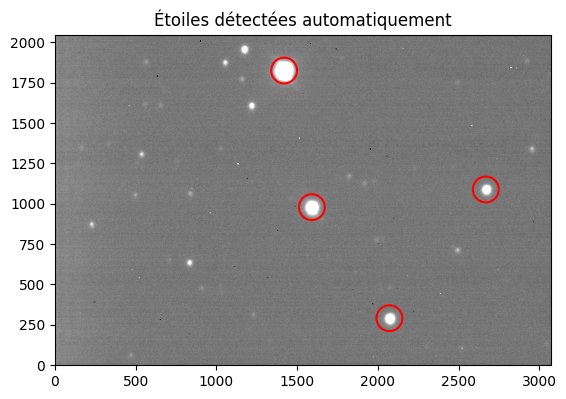

Étoile 1:  id xcentroid ycentroid sharpness  roundness1  roundness2 npix    peak      flux      mag    daofind_mag
--- --------- --------- ---------- ---------- ----------- ---- --------- --------- --------- -----------
 20 1419.5196 1824.8863 0.35589644 0.20009805 0.020949222  169 19592.509 2763095.7 -16.10349  -6.0910292
Étoile 2:  id xcentroid ycentroid sharpness  roundness1  roundness2 npix   peak      flux      mag     daofind_mag
--- --------- --------- ---------- ---------- ----------- ---- -------- --------- ---------- -----------
 13 1591.2973 978.88315 0.41669598 0.20508955 0.070373257  169 4834.904 649985.05 -14.532258  -4.6897735
Étoile 3:  id xcentroid ycentroid sharpness   roundness1  roundness2 npix    peak      flux      mag     daofind_mag
--- --------- --------- ---------- ----------- ----------- ---- --------- --------- ---------- -----------
  3 2071.8432 290.93785 0.45977402 0.039340918 -0.21198733  169 1447.5706 194942.67 -13.224767   -3.265756
Étoile 4:  id xcent

In [7]:
## Determiner positions des etoiles
# Charger une image FITS
image_data = ccdp.CCDData.read(fits_files[0], unit='adu').data

# Calculer le bruit de fond (background noise) et la médiane
mean, median, std = np.mean(image_data), np.median(image_data), mad_std(image_data)

# Initialiser DAOStarFinder avec un seuil de détection
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
sources = daofind(image_data - median)

# Filtrer les colonnes des résultats et afficher
for col in sources.colnames:
    sources[col].info.format = '%.8g'  

# Trier les étoiles par flux décroissant (le flux est proportionnel à la luminosité) -> les 4 premieres etoiles detectees sont les notres
sorted_sources = sources[np.argsort(sources['flux'])[::-1]]

# Extraire les positions des étoiles détectées
star_positions = np.transpose((sorted_sources['xcentroid'], sorted_sources['ycentroid']))

# Afficher l'image avec les positions des étoiles détectées
plt.figure()
interval = ZScaleInterval()
z1, z2 = interval.get_limits(image_data)
plt.imshow(image_data, origin='lower', vmin=z1, vmax=z2, cmap='gray')

# Tracer les apertures sur les étoiles détectées
apertures = CircularAperture(star_positions[:4], r=80.) 
apertures.plot(color='red', lw=1.5)

plt.title('Étoiles détectées automatiquement')
plt.show()

# Afficher toutes les lignes une par une
for i, source in enumerate(sorted_sources[:4]):
    print(f"Étoile {i + 1}: {source}")

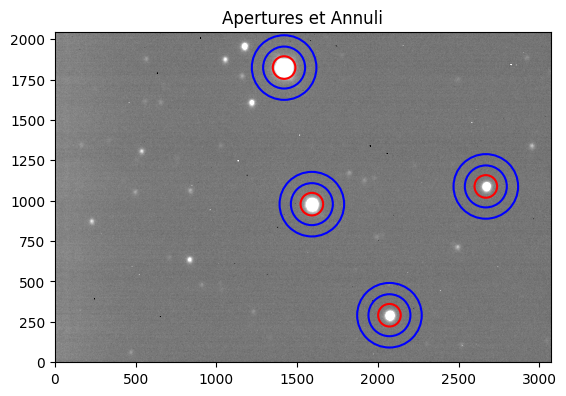

In [8]:
## Determiner aperture et annulus
# Positions des étoiles détectées
star_positions = star_positions[:4]

# Définir l'aperture pour chaque étoile
aperture_radius = 70  # Rayon de l'aperture en pixels
apertures = CircularAperture(star_positions, r=aperture_radius)

# Définir un annulus pour chaque étoile pour estimer le fond
annulus_inner_radius = 130  # Rayon interne de l'annulus
annulus_outer_radius = 200  # Rayon externe de l'annulus
annuli = CircularAnnulus(star_positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

# Tracer les apertures et les annuli sur l'image
plt.figure()
plt.imshow(image_data, origin='lower', vmin=z1, vmax=z2, cmap='gray')
apertures.plot(color='red', lw=1.5)
annuli.plot(color='blue', lw=1.5)
plt.title('Apertures et Annuli')
plt.show()

In [9]:
pos=star_positions
print(pos)
# Coordonnées de l'étoile cible et des étoiles de référence
star_positions = [pos[0],pos[2],pos[3]]
target_position = pos[1]

[[1419.51962202 1824.88628461]
 [1591.29726151  978.88315028]
 [2071.84318075  290.93784869]
 [2668.77788603 1088.65374983]]


Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0001r.fit
2460578.5925578703
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0002r.fit
2460578.592780671
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0003r.fit
2460578.5929987268
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0004r.fit
2460578.5932131945
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0005r.fit
2460578.5934277778
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0006r.fit
2460578.5936561343
Traitement du fichier :

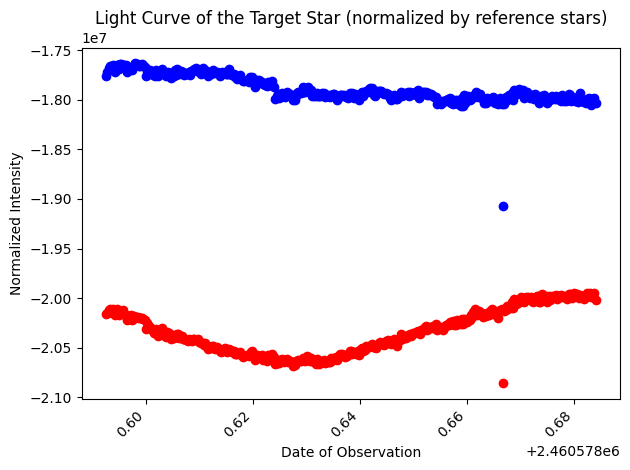

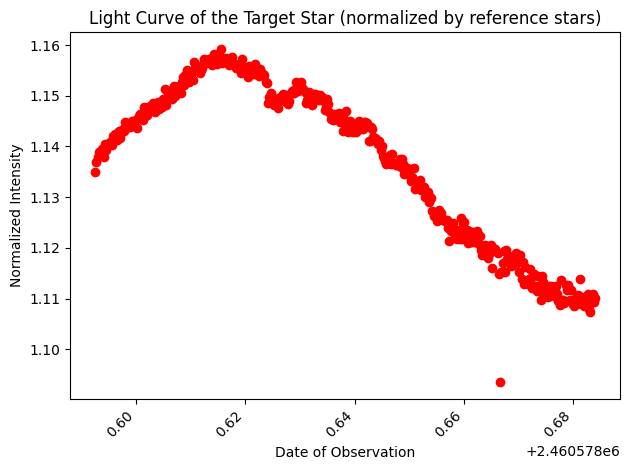

In [10]:
from astropy.time import Time

# Initialiser des listes pour stocker les résultats d'intensité et les dates d'observation
target_intensities = []
reference_intensities = []
observation_dates = []  # Pour stocker les dates d'observation

# Parcourir les fichiers d'observation
for fits_file in fits_files:
    print(f"Traitement du fichier : {fits_file}")
    
    # Charger l'image CCD et extraire la date d'observation
    with fits.open(fits_file) as hdu:
        header = hdu[0].header
        date_obs = header.get('DATE-OBS', None)  # Récupérer la date d'observation
        if date_obs is not None:
            observation_dates.append(Time(date_obs).jd)  # Convertir en format ISO et ajouter à la liste
        print(Time(date_obs).jd)
        ccd_sci = CCDData(hdu[0].data, unit='adu')  # Charger les données CCD
    
    # Photométrie pour l'étoile cible
    target_aperture = CircularAperture(target_position, r=aperture_radius)
    target_annulus = CircularAnnulus(target_position, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    
    # Photométrie pour les étoiles de référence
    reference_apertures = CircularAperture(star_positions, r=aperture_radius)
    reference_annuli = CircularAnnulus(star_positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    
    # Calculer les intensités avec photométrie d'aperture
    phot_table_target = aperture_photometry(ccd_sci.data, target_aperture)
    phot_table_ref = aperture_photometry(ccd_sci.data, reference_apertures)
    
    # Extraire la somme d'intensité pour l'étoile cible et les étoiles de référence
    target_intensity = phot_table_target['aperture_sum'][0]
    reference_intensity = np.mean(phot_table_ref['aperture_sum'])  # Moyenne des intensités des étoiles de référence
    
    # Stocker les intensités
    target_intensities.append(target_intensity)
    reference_intensities.append(reference_intensity)

# Calculer la courbe de lumière normalisée
light_curve = np.array(target_intensities) / np.array(reference_intensities)

print(light_curve)

# Afficher la courbe de lumière avec la date d'observation sur l'axe des x
plt.figure()
plt.plot(observation_dates, target_intensities, marker ='o', linestyle = ' ', color = 'red')
plt.plot(observation_dates, reference_intensities, marker ='o', linestyle = ' ', color = 'blue')
plt.xticks(rotation=45, ha='right')  # Tourner les étiquettes des dates pour une meilleure lisibilité
plt.xlabel('Date of Observation')
plt.ylabel('Normalized Intensity')
plt.title('Light Curve of the Target Star (normalized by reference stars)')
plt.tight_layout()  # Pour éviter les chevauchements

plt.savefig('light_curve.png', dpi=300)

plt.show()
plt.figure()
plt.plot(observation_dates, light_curve, marker ='o', linestyle = ' ', color = 'red')
plt.xticks(rotation=45, ha='right')  # Tourner les étiquettes des dates pour une meilleure lisibilité
plt.xlabel('Date of Observation')
plt.ylabel('Normalized Intensity')
plt.title('Light Curve of the Target Star (normalized by reference stars)')
plt.tight_layout()  # Pour éviter les chevauchements

plt.savefig('light_curve.png', dpi=300)

plt.show()
